## Семинар 1 "Полносвязные нейронные сети"

ФИО: 

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронную сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as pl
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


In [11]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.w = np.random.rand(output_size, input_size) / 10.0
        self.b = np.random.rand(output_size)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        return np.dot(X, self.w.T) + self.b
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdw = np.dot(dLdy.T, self.X)
        self.dLdb = np.sum(dLdy, axis=0)
        return np.dot(dLdy, self.w)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        self.w -= learning_rate * self.dLdw
        self.b -= learning_rate * self.dLdb

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [12]:
def check_gradient(func, X, gradient, verbose=False, eps=1e-6):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    #### YOUR CODE HERE
    g = np.empty_like(X)
    for index, _ in np.ndenumerate(X):
        X[index] += eps
        right = func(X)
        X[index] -= 2 * eps
        left = func(X)
        X[index] += eps
        g[index] = (right - left) / (2 * eps)
    if verbose:
        print(g)
    return np.max(np.abs(g - gradient))

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [13]:
#### YOUR CODE HERE
# dL/dx
input_size = 30
output_size = 20
N = 10
lin = Linear(input_size=input_size, output_size=output_size)

def func_L_x(X):
    # let L = \sum y. Then dL/dy = \vec{1}
    return np.sum(lin.forward(X))
X = np.random.rand(N, input_size)
lin.forward(X)
print('DdL/dx: ', check_gradient(func_L_x, X, lin.backward(np.ones((N, output_size)))))

# dL/dw
def func_L_w(w):
    lin.w = w
    return np.sum(lin.forward(X))
print('DdL/dw: ', check_gradient(func_L_w, lin.w, lin.dLdw))

# dL/db
def func_L_b(b):
    lin.b = b
    return np.sum(lin.forward(X))
print('DdL/db: ', check_gradient(func_L_b, lin.b, lin.dLdb))

DdL/dx:  4.57427178358e-08
DdL/dw:  4.86256954702e-08
DdL/db:  3.15958459396e-08


### Часть 3: Сигмоида

In [14]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        return 1 / (1 + np.exp(-X))
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        return dLdy * (self.forward(self.X) * (1 - self.forward(self.X)))
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [15]:
#### YOUR CODE HERE
input_size = 30
N = 10
sig = Sigmoid()

def func_sig_L_x(X):
    # let L = \sum y. Then dL/dy = \vec{1}
    return np.sum(sig.forward(X))

X = np.random.rand(N, input_size)
sig.forward(X)

print('DdL/dx: ', check_gradient(func_sig_L_x, X, sig.backward(np.ones((N, input_size)))))

DdL/dx:  1.72718641334e-08


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [16]:
class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        self.y = y
        self.p = np.exp(X) / np.sum(np.exp(X), axis=1, keepdims=True)
        return -np.mean(np.log(self.p[np.arange(X.shape[0]), y]))
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdx = self.p.copy()
        dLdx[np.arange(self.X.shape[0]), self.y] -= 1
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [18]:
#### YOUR CODE HERE
X = np.array([
    [1,0,0],
], dtype='float32')
y = np.array([
    0,
])

snll = NLLLoss()
snll.forward(X, y)
g = snll.backward()

def func_snll_L_x(X):
    return snll.forward(X, y)



print('DdL/dx: ', check_gradient(func_snll_L_x, X, g, eps=1e-2))

DdL/dx:  1.72853e-06


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [5]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.modules = modules
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        for m in self.modules:
            X = m.forward(X)
        
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        for m in self.modules[::-1]:
            dLdy = m.backward(dLdy)
        
    
    def step(self, learning_rate):
        for m in self.modules:
            m.step(learning_rate)

### Часть 6, обучение на простых данных

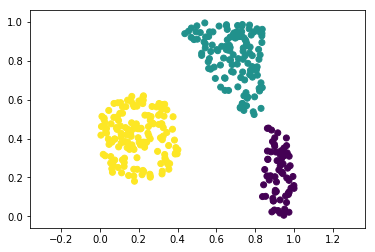

In [6]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.01). 
2. Нарисуйте график сходимости (изменение NLL со временем).
3. Нарисуйте разделяющую поверхность

Отличная визуализация: http://playground.tensorflow.org/

In [8]:
### YOUR CODE HERE:
nn = NeuralNetwork([
    Linear(2, 10),
    Sigmoid(),
    Linear(10, 10),
    Sigmoid(),
    Linear(10, 3),
])
# print(X)
# print(y)
nll = NLLLoss()
losses = []
for i in range(500):
    y_ = nn.forward(X)
    loss = nll.forward(y_, y)
    if i % 10 == 0:
        losses.append(loss)
        print(i, ': ', loss)
    dLdy = nll.backward()
    nn.backward(dLdy)
    nn.step(1e-2)

0 :  1.15747357779
10 :  1.05234246708
20 :  1.05149339083
30 :  1.05051496986
40 :  1.04924126951
50 :  1.0473657413
60 :  1.04420567707
70 :  1.0379111025
80 :  1.02214793522
90 :  0.971367313896
100 :  0.832101521392
110 :  0.657012318068
120 :  0.510077355496
130 :  0.384937733738
140 :  0.306761704719
150 :  0.260554376345
160 :  2.07091044227
170 :  0.534821796751
180 :  0.425595744285
190 :  0.351851878424
200 :  0.275463385713
210 :  0.276422585808
220 :  0.359618908515
230 :  0.203616288537
240 :  0.157463732764
250 :  0.140050479279
260 :  0.130428977332
270 :  0.184221717299
280 :  0.264416463367
290 :  0.0681009169263
300 :  0.0522818631879
310 :  0.0416976913074
320 :  0.0341851791645
330 :  0.0286535758099
340 :  0.0244672815039
350 :  0.0212253926108
360 :  0.018663608559
370 :  0.0166025007236
380 :  0.0149173740784
390 :  0.0135197563473
400 :  0.0123456667721
410 :  0.0113480090766
420 :  0.0104915406693
430 :  0.00974948440634
440 :  0.00910120682996
450 :  0.0085306

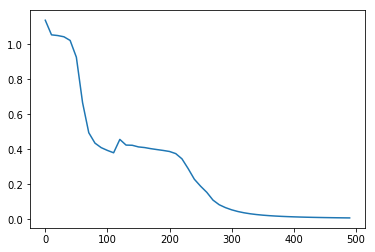

In [323]:
plt.plot(range(0, 500, 10), losses)

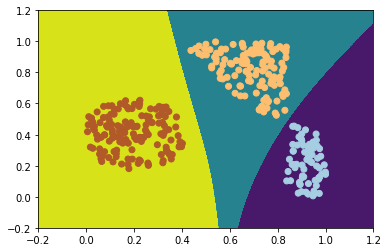

In [324]:
h = 0.001
x_min, x_max = -0.2, 1.2
y_min, y_max = -0.2, 1.2
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))


# here "model" is your model's prediction (classification) function
xr = xx.ravel()
yr = yy.ravel()
xy = np.vstack((xr, yr)).T

y_ = np.argmax(nn.forward(xy), axis=1)

# Put the result into a color plot
y_ = y_.reshape(xx.shape)
plt.contourf(xx, yy, y_)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=pl.cm.Paired)
# plt.show()

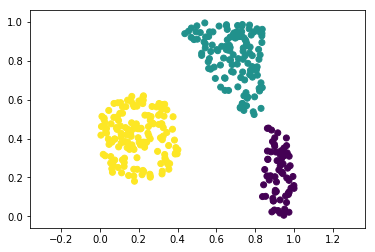

In [269]:
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y_, axis=1))
plt.axis('equal')
plt.show()